# Problem 2: Getting familiar with TensorFlow

*TensorFlow* is one of the most popular deep learning framework developed by Google. If you are new to TensorFlow, please read and play with the sample in [Getting started with TensorFlow](https://www.tensorflow.org/get_started/get_started) to get started.

* <b>Learning Objective:</b> In Problem 1, you implemented a fully connected network from scratch on your own. Very tedious to do it all by yourself, right? Well, we actually feel the same thing, that's why we are using tools instead of doing everything from scratch. For this part of the assignment, we will familiarize you with a widely-used deep learning framework developed by Google, TensorFlow and walk you through convolutional neural networks and show how to train them.
* <b>Provided Codes:</b> We provide the Template class for a simple CNN model as BaseModel, predefined skeletons for conv2d() and max_pool(), as well as the dataset preprocessing parts.
* <b>TODOs:</b> You are asked to implement the BaseModel following the detailed instructions and design your own model in YourModel to achieve a reasonably good performance for classification task on CIFAR-10 dataset.

## Import libraries

In [1]:
# Import required libraries
# Add whatever you want
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from lib.datasets import CIFAR10_tf

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

print("TensorFlow Version {}".format(tf.__version__))

TensorFlow Version 1.12.0


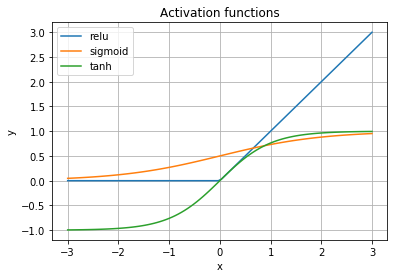

In [2]:
# Test matplotlib
x = np.linspace(-3, 3, 100)

plt.plot(x, np.maximum(0, x), label='relu')
plt.plot(x, 1/(1 + np.exp(-x)), label='sigmoid')
plt.plot(x, (1 - np.exp(-2 * x))/(1 + np.exp(-2 * x)), label='tanh')

plt.xlabel('x')
plt.ylabel('y')

plt.title("Activation functions")
plt.legend()
plt.grid(True)

plt.show()

In [3]:
# Test tensorflow
print('TensorFlow version: ' + tf.__version__)
a = tf.constant(2.0)
b = tf.constant(3.0)
c = a * b

sess = tf.Session()
result = sess.run([a, b, c])
print('%f * %f = %f' % (result[0], result[1], result[2]))
sess.close()

TensorFlow version: 1.12.0
2.000000 * 3.000000 = 6.000000


## Load datasets
Download [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz) and load the dataset. In this assignment, we will use the standard 50,000 images for training and 10,000 images for test.

In [4]:
# Configuration
num_training = 49000
num_validation = 50000 - num_training
num_test = 10000

data = CIFAR10_tf(num_training=num_training,
                  num_validation=num_validation,
                  num_test=num_test)

# Load cifar-10 data
X_train, Y_train = data['data_train'], data['labels_train']
X_val, Y_val = data['data_val'], data['labels_val']
X_test, Y_test = data['data_test'], data['labels_test']

# Check the shape of the dataset
assert X_train.shape == (num_training, 32, 32, 3)
assert Y_train.shape == (num_training, )
assert X_val.shape == (num_validation, 32, 32, 3)
assert Y_val.shape == (num_validation, )
assert X_test.shape == (num_test, 32, 32, 3)
assert Y_test.shape == (10000, )

## Question 2-1

Using the code provided, implement a neural network architecture with an optimization routine according to the specification provided below.

**Model:**
- Input image with the size 32x32x3
- 7x7 convolutional layer with 32 filters, stride of 1, and padding 'SAME'
- ReLU activation layer
- 3x3 max pooling layer with a stride of 2
- 5x5 convolutional layer with 64 filters, stride of 1, and padding 'SAME'
- ReLU activation layer
- 3x3 max pooling layer with a stride of 2
- Flatten layer (8x8x64 -> 4096)
- Fully-connected layer with 384 output units (4096 -> 384)
- ReLU activation layer
- Fully-connected layer with 10 output units (384 -> 10)
- Output logits (10)

**Optimizer:**
- Adam optimizer

**Learning rate:**
- Set start learning rate as 5e-4 and apply exponential decay every 500 steps with a base of 0.96
- Use 'tf.train.exponential_decay' and 'tf.train.AdamOptimizer'

**Loss:**
- Softmax cross entropy loss
- Use 'tf.nn.softmax_cross_entropy_with_logits'


Your model **should** achieve about 60% accuracy on validation set in 5 epochs using provided evaluation code.

You can modify the template code as you want.

## Define your layers

In [5]:
# Define max pooling and conv layers

def conv2d(input, kernel_size, stride, num_filter):
    stride_shape = [1, stride, stride, 1]
    filter_shape = [kernel_size, kernel_size, input.get_shape()[3], num_filter]

    W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.02))
    b = tf.get_variable('b', [1, 1, 1, num_filter], initializer=tf.constant_initializer(0.0))
    return tf.nn.conv2d(input, W, stride_shape, padding='SAME') + b

def max_pool(input, kernel_size, stride):
    ksize = [1, kernel_size, kernel_size, 1]
    strides = [1, stride, stride, 1]
    return tf.nn.max_pool(input, ksize=ksize, strides=strides, padding='SAME')

#############################################################################
# TODO: Complete the following functions                                    #
#############################################################################
def flatten(input):
    """
        - input: input tensors
    """
    return tf.layers.flatten(input)

def fc(input, num_output):
    """
        - input: input tensors
        - num_output: int, the output dimension
    """
    return tf.layers.dense(input, num_output)

def norm(input, is_training):
    """
        - input: input tensors
        - is_training: boolean, if during training or not
    """
    # Is this input normalization or batch normalization??
    return tf.layers.batch_normalization(input, training = is_training)
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

## Sample convolutional neural network

In [6]:
# Helper class to define hyper parameters so that I can test 
# different combinations to run the learning phases (train / validate / test).
# This class only exposes options like a config, it's upto the model implementation
# class to use/ignore those options.
class Options:
    def __init__(self, num_cnn=2, num_fc=2, use_dropout=False, use_batch_norm=False, num_epoch=10, lrDecay=None):
        self.num_cnn = num_cnn
        self.num_fc = num_fc
        self.use_dropout = use_dropout
        self.use_batch_norm = use_batch_norm
        self.num_epoch = num_epoch
        self.lrDecay = lrDecay #TODO: Not handled in YourModel class yet
        
    def __str__(self):
        return str.format("num_cnn = {}, num_fc = {}, use_dropout = {}, use_batch_norm = {}, num_epoch = {}, lrDecay = {}",
                         self.num_cnn, self.num_fc, self.use_dropout, self.use_batch_norm, self.num_epoch, self.lrDecay)
        

In [7]:
class BaseModel(object):
    def __init__(self, options = None):
        self.options = options #Base class does not use this for now, meant for child class
        self.num_epoch = 5
        self.batch_size = 128
        self.log_step = 50
        self._build_model()

    def _model(self):
        print('-' * 5 + '  Sample model  ' + '-' * 5)

        print('intput layer: ' + str(self.X.get_shape()))

        with tf.variable_scope('conv1'):
            self.conv1 = conv2d(self.X, 7, 1, 32)
            self.relu1 = tf.nn.relu(self.conv1)
            self.pool1 = max_pool(self.relu1, 3, 2)            
            print('conv1 layer: ' + str(self.pool1.get_shape()))

        with tf.variable_scope('conv2'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.conv2 = conv2d(self.pool1, 5, 1, 64)
            self.relu2 = tf.nn.relu(self.conv2)
            self.pool2 = max_pool(self.relu2, 3, 2)                        
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('conv2 layer: ' + str(self.pool2.get_shape()))

        #############################################################################
        # TODO: Flatten the output tensor from conv2 layer                          #
        #############################################################################
        self.flat = flatten(self.pool2)
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################      
        print('flat layer: ' + str(self.flat.get_shape()))

        with tf.variable_scope('fc3'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.fc3 = fc(self.flat, 384)
            self.relu3 = tf.nn.relu(self.fc3)
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('fc3 layer: ' + str(self.relu3.get_shape()))
            
        with tf.variable_scope('fc4'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.fc4 = fc(self.relu3, 10)
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('fc4 layer: ' + str(self.fc4.get_shape()))
            
        # Return the last layer
        return self.fc4

    def _input_ops(self):
        # Placeholders
        self.X = tf.placeholder(tf.float32, [None, 32, 32, 3])
        self.Y = tf.placeholder(tf.int64, [None])

        #############################################################################
        # TODO: You can add any placeholders                                        #
        #############################################################################
        self.is_training = tf.placeholder(tf.bool)
        self.keep_prob = tf.placeholder(tf.float32)
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def _build_optimizer(self):
        # Adam optimizer 'self.train_op' that minimizes 'self.loss_op'
        #############################################################################
        # TODO: Complete the following functions                                    #
        #############################################################################
        global_step = tf.Variable(0, trainable=False)        
        learning_rate = tf.train.exponential_decay(5e-4, global_step, 500, 0.96, staircase=True)
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        self.train_op = optimizer.minimize(self.loss_op, global_step=global_step)
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
        
    def _loss(self, labels, logits):
        # Softmax cross entropy loss 'self.loss_op'
        #############################################################################
        # TODO: Complete the following functions                                    #
        #############################################################################
        self.loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels))
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def _build_model(self):
        # Define input variables
        self._input_ops()

        # Convert Y to one-hot vector
        labels = tf.one_hot(self.Y, 10)

        # Build a model and get logits
        logits = self._model()

        # Compute loss
        self._loss(labels, logits)
        
        # Build optimizer
        self._build_optimizer()

        # Compute accuracy
        predict = tf.argmax(logits, 1)
        correct = tf.equal(predict, self.Y)
        self.accuracy_op = tf.reduce_mean(tf.cast(correct, tf.float32))
        
    def train(self, sess, X_train, Y_train, X_val, Y_val):
        sess.run(tf.global_variables_initializer())

        step = 0
        losses = []
        accuracies = []
        print('-' * 5 + '  Start training  ' + '-' * 5)
        for epoch in range(self.num_epoch):
            print('train for epoch %d' % epoch)
            for i in range(num_training // self.batch_size):
                X_ = X_train[i * self.batch_size:(i + 1) * self.batch_size][:]
                Y_ = Y_train[i * self.batch_size:(i + 1) * self.batch_size]

                #############################################################################
                # TODO: You can change feed data as you want                                #
                #############################################################################
                feed_dict = {self.X: X_, self.Y: Y_, self.is_training: True, self.keep_prob: 0.5}
                #############################################################################
                #                             END OF YOUR CODE                              #
                #############################################################################
                fetches = [self.train_op, self.loss_op, self.accuracy_op]

                _, loss, accuracy = sess.run(fetches, feed_dict=feed_dict)
                losses.append(loss)
                accuracies.append(accuracy)

                if step % self.log_step == 0:
                    print('iteration (%d): loss = %.3f, accuracy = %.3f' %
                        (step, loss, accuracy))
                step += 1

            # Print validation results
            print('validation for epoch %d' % epoch)
            val_accuracy = self.evaluate(sess, X_val, Y_val)
            print('-  epoch %d: validation accuracy = %.3f' % (epoch, val_accuracy))
            
        #############################################################################
        # TODO: Plot training curve                                                 #
        #############################################################################
        # Graph 1. X: epoch, Y: training loss
        plt.plot(range(self.num_epoch * (num_training // self.batch_size)), losses, label='Training Loss')

        plt.xlabel('Epoch')
        plt.ylabel('Loss')

        plt.title("Loss")
        plt.legend()
        
        plt.show()        
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def evaluate(self, sess, X_eval, Y_eval):
        eval_accuracy = 0.0
        eval_iter = 0
        for i in range(X_eval.shape[0] // self.batch_size):
            X_ = X_eval[i * self.batch_size:(i + 1) * self.batch_size][:]
            Y_ = Y_eval[i * self.batch_size:(i + 1) * self.batch_size]
            
            #############################################################################
            # TODO: You can change feed data as you want                                #
            #############################################################################
            feed_dict = {self.X: X_, self.Y: Y_, self.is_training: False, self.keep_prob: 1.0}
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            accuracy = sess.run(self.accuracy_op, feed_dict=feed_dict)
            eval_accuracy += accuracy
            eval_iter += 1
        return eval_accuracy / eval_iter

-----  Sample model  -----
intput layer: (?, 32, 32, 3)
conv1 layer: (?, 16, 16, 32)
conv2 layer: (?, 8, 8, 64)
flat layer: (?, 4096)
fc3 layer: (?, 384)
fc4 layer: (?, 10)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

-----  Start training  -----
train for epoch 0
iteration (0): loss = 2460.687, accuracy = 0.078
iteration (50): loss = 270.282, accuracy = 0.266
iteration (100): loss = 254.601, accuracy = 0.266
iteration (150): loss = 220.953, accuracy = 0.328
iteration (200): loss = 223.947, accuracy = 0.398
iteration (250): loss = 213.998, accuracy = 0.383
iteration (300): loss = 185.374, accuracy = 0.500
iteration (350): loss = 198.645, accuracy = 0.438
validation for epoch 0
-  epoch 0: validation accuracy = 0.515
train for epoch 1
iteration (400): loss = 188.789, accuracy = 0.469
iteration (450): loss = 181.430, accuracy = 0.508
iteration 

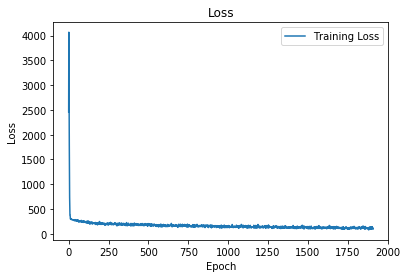

***** test accuracy: 0.608
Model saved in lib/tf_models/problem2/csci-599_sample.ckpt


In [7]:
# Clear old computation graphs
tf.reset_default_graph()

# Train our sample model
with tf.Session() as sess:
    with tf.device('/cpu:0'):
        model = BaseModel()
        model.train(sess, X_train, Y_train, X_val, Y_val)
        accuracy = model.evaluate(sess, X_test, Y_test)
        print('***** test accuracy: %.3f' % accuracy)
        saver = tf.train.Saver()
        model_path = saver.save(sess, "lib/tf_models/problem2/csci-599_sample.ckpt")
        print("Model saved in %s" % model_path)

## Question 2-2

Implement your own model. 

You can modify the template code as you want and you can use GPU for fast training.  
For GPU usage, simply change the following line of the training block:  
from `with tf.device('/cpu:0')` to `with tf.device('/GPU:0')`  
and you can set your desired device number  

These are the techniques that you can try:
- Data preprocessing
- Data augmentation
- Dropout
- Batch normalization
- More convolutional layers
- More training epochs
- Learning rate decay
- Any other models and techniqes

Your model should achieve >= 70% accuracy on the test set of CIFAR-10.

If the accuracy of the model reaches to 80%, you will get 5 extra points.

In [8]:
class YourModel(BaseModel):
    def __init__(self, options):
        if (options is None):
            options = Options()
        super(YourModel, self).__init__(options)
        self.num_epoch = options.num_epoch

    def _model(self):
        options = self.options
        
        print('-' * 5 + '  Your model  ' + '-' * 5)

        #############################################################################
        # TODO: Implement you own model here                                        #
        #############################################################################        
        print('-' * 5 + '  Sample model  ' + '-' * 5)
        print('intput layer: ' + str(self.X.get_shape()))

        with tf.variable_scope('conv1'):
            self.conv1 = conv2d(self.X, 7, 1, 32)
            self.relu1 = tf.nn.relu(self.conv1)
            self.pool1 = max_pool(self.relu1, 3, 2)            
            print('conv1 layer: ' + str(self.pool1.get_shape()))

        with tf.variable_scope('conv2'):
            self.conv2 = conv2d(self.pool1, 5, 1, 64)
            self.relu2 = tf.nn.relu(self.conv2)
            self.pool2 = max_pool(self.relu2, 3, 2)                        
            print('conv2 layer: ' + str(self.pool2.get_shape()))
            last_conv = self.pool2
        
        if (options.num_cnn >= 3):
            with tf.variable_scope('conv3'):
                self.conv3 = conv2d(self.pool2, 5, 1, 64)
                self.relu3 = tf.nn.relu(self.conv3)
                self.pool3 = max_pool(self.relu3, 3, 2)                        
                print('conv3 layer: ' + str(self.pool3.get_shape()))
                last_conv = self.pool3

        if (options.num_cnn >= 4):
            with tf.variable_scope('conv4'):
                self.conv4 = conv2d(self.pool3, 3, 1, 128)
                self.relu4 = tf.nn.relu(self.conv4)
                self.pool4 = max_pool(self.relu4, 3, 2)                        
                print('conv4 layer: ' + str(self.pool4.get_shape()))
                last_conv = self.pool4

        if (options.num_cnn >= 5):
            with tf.variable_scope('conv5'):
                self.conv5 = conv2d(self.pool4, 3, 1, 128)
                self.relu5 = tf.nn.relu(self.conv5)
                self.pool5 = max_pool(self.relu5, 3, 1)                        
                print('conv5 layer: ' + str(self.pool5.get_shape()))
                last_conv = self.pool5
                
        self.flat = flatten(last_conv)
        print('flat layer: ' + str(self.flat.get_shape()))

        with tf.variable_scope('fc6'):
            self.fc6 = fc(self.flat, 384)
            self.norm6 = norm(self.fc6, self.is_training) if options.use_batch_norm else self.fc6 
            self.relu6 = tf.nn.relu(self.norm6)
            print('fc6 layer: ' + str(self.relu6.get_shape()))
            last_fc = self.relu6
            
        if (options.use_dropout):
            last_fc = tf.nn.dropout(last_fc, self.keep_prob)

        if (options.num_fc >= 3):
            with tf.variable_scope('fc7'):
                self.fc7 = fc(last_fc, 192)
                self.norm7 = norm(self.fc7, self.is_training) if options.use_batch_norm else self.fc7 
                self.relu7 = tf.nn.relu(self.fc7)
                print('fc7 layer: ' + str(self.relu7.get_shape()))            
                last_fc = self.relu7
            
        if (options.use_dropout):
            last_fc = tf.nn.dropout(last_fc, self.keep_prob)

        with tf.variable_scope('fc8'):
            self.fc8 = fc(last_fc, 10)
            print('fc8 layer: ' + str(self.fc8.get_shape()))
            
        # Return the last layer
        return self.fc8
    
    def _build_optimizer(self):
        # Adam optimizer 'self.train_op' that minimizes 'self.loss_op'
        global_step = tf.Variable(0, trainable=False)        
        learning_rate = tf.train.exponential_decay(5e-4, global_step, 500, 0.96, staircase=True)
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            self.train_op = optimizer.minimize(self.loss_op, global_step=global_step)
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

In [9]:
# Making a function out of the block below to try a few hyper paramter combinations
# (so that I can keep the system running while I am doing something else)
def reset_and_train(options):
    print ("------------------------------------------------------------------------")
    print (str.format("Learning started with options : {}", options))
    print ("------------------------------------------------------------------------")
    # Clear old computation graphs
    tf.reset_default_graph()

    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################

    with tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)) as sess:
        with tf.device('/gpu:0'):
            model = YourModel(options)
            model.train(sess, X_train, Y_train, X_val, Y_val)
            accuracy = model.evaluate(sess, X_test, Y_test)
            print('***** test accuracy: %.3f' % accuracy)

------------------------------------------------------------------------
Learning started with options : num_cnn = 5, num_fc = 3, use_dropout = False, use_batch_norm = True, num_epoch = 3, lrDecay = None
------------------------------------------------------------------------
-----  Your model  -----
-----  Sample model  -----
intput layer: (?, 32, 32, 3)
conv1 layer: (?, 16, 16, 32)
conv2 layer: (?, 8, 8, 64)
conv3 layer: (?, 4, 4, 64)
conv4 layer: (?, 2, 2, 128)
conv5 layer: (?, 2, 2, 128)
flat layer: (?, 512)
fc6 layer: (?, 384)
fc7 layer: (?, 192)
fc8 layer: (?, 10)
-----  Start training  -----
train for epoch 0
iteration (0): loss = 348.294, accuracy = 0.117
iteration (50): loss = 198.119, accuracy = 0.430
iteration (100): loss = 169.944, accuracy = 0.461
iteration (150): loss = 167.615, accuracy = 0.492
iteration (200): loss = 166.907, accuracy = 0.547
iteration (250): loss = 152.240, accuracy = 0.555
iteration (300): loss = 146.762, accuracy = 0.633
iteration (350): loss = 141.1

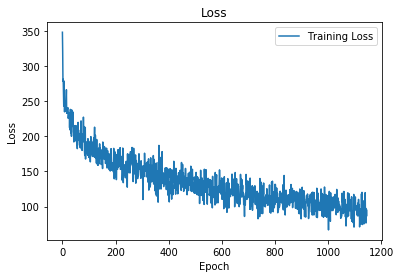

***** test accuracy: 0.671
------------------------------------------------------------------------
Learning started with options : num_cnn = 5, num_fc = 3, use_dropout = True, use_batch_norm = False, num_epoch = 3, lrDecay = None
------------------------------------------------------------------------
-----  Your model  -----
-----  Sample model  -----
intput layer: (?, 32, 32, 3)
conv1 layer: (?, 16, 16, 32)
conv2 layer: (?, 8, 8, 64)
conv3 layer: (?, 4, 4, 64)
conv4 layer: (?, 2, 2, 128)
conv5 layer: (?, 2, 2, 128)
flat layer: (?, 512)
fc6 layer: (?, 384)
fc7 layer: (?, 192)
fc8 layer: (?, 10)
-----  Start training  -----
train for epoch 0
iteration (0): loss = 521.975, accuracy = 0.047
iteration (50): loss = 267.579, accuracy = 0.211
iteration (100): loss = 238.449, accuracy = 0.281
iteration (150): loss = 235.965, accuracy = 0.281
iteration (200): loss = 224.961, accuracy = 0.344
iteration (250): loss = 213.585, accuracy = 0.359
iteration (300): loss = 182.962, accuracy = 0.484
it

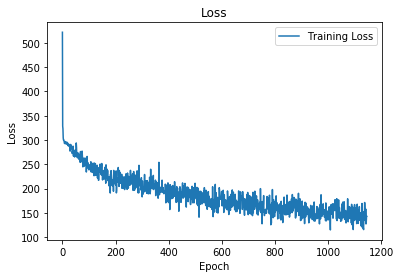

***** test accuracy: 0.601
------------------------------------------------------------------------
Learning started with options : num_cnn = 5, num_fc = 3, use_dropout = True, use_batch_norm = True, num_epoch = 3, lrDecay = None
------------------------------------------------------------------------
-----  Your model  -----
-----  Sample model  -----
intput layer: (?, 32, 32, 3)
conv1 layer: (?, 16, 16, 32)
conv2 layer: (?, 8, 8, 64)
conv3 layer: (?, 4, 4, 64)
conv4 layer: (?, 2, 2, 128)
conv5 layer: (?, 2, 2, 128)
flat layer: (?, 512)
fc6 layer: (?, 384)
fc7 layer: (?, 192)
fc8 layer: (?, 10)
-----  Start training  -----
train for epoch 0
iteration (0): loss = 363.241, accuracy = 0.125
iteration (50): loss = 258.893, accuracy = 0.242
iteration (100): loss = 229.439, accuracy = 0.281
iteration (150): loss = 229.039, accuracy = 0.273
iteration (200): loss = 209.015, accuracy = 0.398
iteration (250): loss = 198.163, accuracy = 0.469
iteration (300): loss = 185.342, accuracy = 0.406
ite

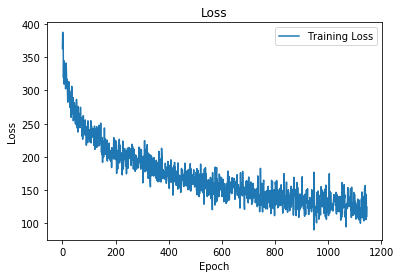

***** test accuracy: 0.585
------------------------------------------------------------------------
Learning started with options : num_cnn = 5, num_fc = 3, use_dropout = False, use_batch_norm = False, num_epoch = 3, lrDecay = None
------------------------------------------------------------------------
-----  Your model  -----
-----  Sample model  -----
intput layer: (?, 32, 32, 3)
conv1 layer: (?, 16, 16, 32)
conv2 layer: (?, 8, 8, 64)
conv3 layer: (?, 4, 4, 64)
conv4 layer: (?, 2, 2, 128)
conv5 layer: (?, 2, 2, 128)
flat layer: (?, 512)
fc6 layer: (?, 384)
fc7 layer: (?, 192)
fc8 layer: (?, 10)
-----  Start training  -----
train for epoch 0
iteration (0): loss = 401.395, accuracy = 0.117
iteration (50): loss = 245.140, accuracy = 0.266
iteration (100): loss = 211.585, accuracy = 0.336
iteration (150): loss = 191.833, accuracy = 0.484
iteration (200): loss = 193.601, accuracy = 0.445
iteration (250): loss = 182.163, accuracy = 0.461
iteration (300): loss = 163.157, accuracy = 0.555
i

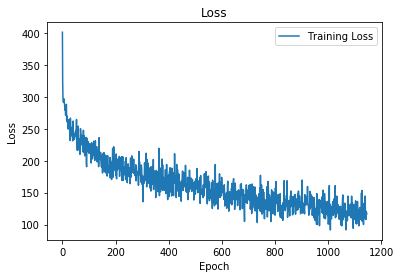

***** test accuracy: 0.639


In [10]:
reset_and_train(Options(num_cnn = 5, use_batch_norm = True, num_fc = 3, num_epoch = 3)) #This will be faster learning
reset_and_train(Options(num_cnn = 5, use_dropout = True, num_fc = 3, num_epoch = 3)) #This is expected to take more epochs to learn but less overfitting 
reset_and_train(Options(num_cnn = 5, use_batch_norm = True, use_dropout = True, num_fc = 3, num_epoch = 3))
reset_and_train(Options(num_cnn = 5, use_batch_norm = False, use_dropout = False, num_fc = 3, num_epoch = 3))

------------------------------------------------------------------------
Learning started with options : num_cnn = 5, num_fc = 3, use_dropout = False, use_batch_norm = True, num_epoch = 20, lrDecay = None
------------------------------------------------------------------------
-----  Your model  -----
-----  Sample model  -----
intput layer: (?, 32, 32, 3)
conv1 layer: (?, 16, 16, 32)
conv2 layer: (?, 8, 8, 64)
conv3 layer: (?, 4, 4, 64)
conv4 layer: (?, 2, 2, 128)
conv5 layer: (?, 2, 2, 128)
flat layer: (?, 512)
fc6 layer: (?, 384)
fc7 layer: (?, 192)
fc8 layer: (?, 10)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

-----  Start training  -----
train for epoch 0
iteration (0): loss = 2.476, accuracy = 0.094
iteration (50): loss = 1.632, accuracy = 0.398
iteration (100): loss = 1.397, accuracy = 0.445
iteration (150): loss = 1.261, accuracy = 0

validation for epoch 15
-  epoch 15: validation accuracy = 0.739
train for epoch 16
iteration (6150): loss = 0.223, accuracy = 0.922
iteration (6200): loss = 0.135, accuracy = 0.938
iteration (6250): loss = 0.138, accuracy = 0.961
iteration (6300): loss = 0.199, accuracy = 0.922
iteration (6350): loss = 0.174, accuracy = 0.953
iteration (6400): loss = 0.094, accuracy = 0.961
iteration (6450): loss = 0.125, accuracy = 0.961
validation for epoch 16
-  epoch 16: validation accuracy = 0.705
train for epoch 17
iteration (6500): loss = 0.128, accuracy = 0.969
iteration (6550): loss = 0.166, accuracy = 0.930
iteration (6600): loss = 0.164, accuracy = 0.938
iteration (6650): loss = 0.126, accuracy = 0.961
iteration (6700): loss = 0.205, accuracy = 0.938
iteration (6750): loss = 0.197, accuracy = 0.930
iteration (6800): loss = 0.081, accuracy = 0.977
iteration (6850): loss = 0.086, accuracy = 0.969
validation for epoch 17
-  epoch 17: validation accuracy = 0.681
train for epoch 18
iteration (69

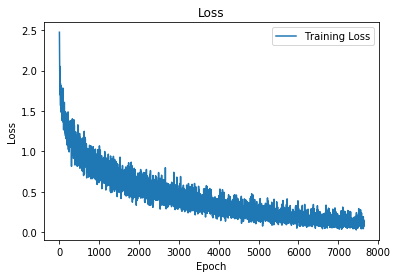

***** test accuracy: 0.693


In [9]:
reset_and_train(Options(num_cnn = 5, use_batch_norm = True, use_dropout = False, num_fc = 3, num_epoch = 20))

------------------------------------------------------------------------
Learning started with options : num_cnn = 5, num_fc = 3, use_dropout = False, use_batch_norm = False, num_epoch = 20, lrDecay = None
------------------------------------------------------------------------
-----  Your model  -----
-----  Sample model  -----
intput layer: (?, 32, 32, 3)
conv1 layer: (?, 16, 16, 32)
conv2 layer: (?, 8, 8, 64)
conv3 layer: (?, 4, 4, 64)
conv4 layer: (?, 2, 2, 128)
conv5 layer: (?, 2, 2, 128)
flat layer: (?, 512)
fc6 layer: (?, 384)
fc7 layer: (?, 192)
fc8 layer: (?, 10)
-----  Start training  -----
train for epoch 0
iteration (0): loss = 2.492, accuracy = 0.109
iteration (50): loss = 1.784, accuracy = 0.383
iteration (100): loss = 1.555, accuracy = 0.406
iteration (150): loss = 1.620, accuracy = 0.375
iteration (200): loss = 1.516, accuracy = 0.453
iteration (250): loss = 1.479, accuracy = 0.461
iteration (300): loss = 1.300, accuracy = 0.516
iteration (350): loss = 1.377, accuracy =

iteration (6450): loss = 0.312, accuracy = 0.883
validation for epoch 16
-  epoch 16: validation accuracy = 0.723
train for epoch 17
iteration (6500): loss = 0.344, accuracy = 0.859
iteration (6550): loss = 0.183, accuracy = 0.945
iteration (6600): loss = 0.311, accuracy = 0.875
iteration (6650): loss = 0.320, accuracy = 0.875
iteration (6700): loss = 0.194, accuracy = 0.945
iteration (6750): loss = 0.233, accuracy = 0.906
iteration (6800): loss = 0.392, accuracy = 0.898
iteration (6850): loss = 0.232, accuracy = 0.898
validation for epoch 17
-  epoch 17: validation accuracy = 0.718
train for epoch 18
iteration (6900): loss = 0.278, accuracy = 0.906
iteration (6950): loss = 0.119, accuracy = 0.953
iteration (7000): loss = 0.398, accuracy = 0.883
iteration (7050): loss = 0.277, accuracy = 0.922
iteration (7100): loss = 0.424, accuracy = 0.844
iteration (7150): loss = 0.269, accuracy = 0.883
iteration (7200): loss = 0.418, accuracy = 0.844
iteration (7250): loss = 0.293, accuracy = 0.859

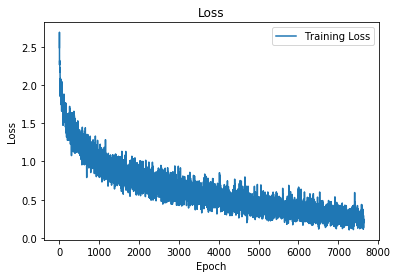

***** test accuracy: 0.691


In [10]:
reset_and_train(Options(num_cnn = 5, use_batch_norm = False, use_dropout = False, num_fc = 3, num_epoch = 20))

------------------------------------------------------------------------
Learning started with options : num_cnn = 5, num_fc = 3, use_dropout = True, use_batch_norm = True, num_epoch = 30, lrDecay = None
------------------------------------------------------------------------
-----  Your model  -----
-----  Sample model  -----
intput layer: (?, 32, 32, 3)
conv1 layer: (?, 16, 16, 32)
conv2 layer: (?, 8, 8, 64)
conv3 layer: (?, 4, 4, 64)
conv4 layer: (?, 2, 2, 128)
conv5 layer: (?, 2, 2, 128)
flat layer: (?, 512)
fc6 layer: (?, 384)
fc7 layer: (?, 192)
fc8 layer: (?, 10)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

-----  Start training  -----
train for epoch 0
iteration (0): loss = 3.155, accuracy = 0.133
iteration (50): loss = 1.995, accuracy = 0.297
iteration (100): loss = 1.755, accuracy = 0.336
iteration (150): loss = 1.698, accuracy = 0.

validation for epoch 15
-  epoch 15: validation accuracy = 0.735
train for epoch 16
iteration (6150): loss = 0.402, accuracy = 0.867
iteration (6200): loss = 0.323, accuracy = 0.906
iteration (6250): loss = 0.505, accuracy = 0.859
iteration (6300): loss = 0.306, accuracy = 0.883
iteration (6350): loss = 0.279, accuracy = 0.914
iteration (6400): loss = 0.465, accuracy = 0.852
iteration (6450): loss = 0.233, accuracy = 0.922
validation for epoch 16
-  epoch 16: validation accuracy = 0.742
train for epoch 17
iteration (6500): loss = 0.277, accuracy = 0.914
iteration (6550): loss = 0.242, accuracy = 0.922
iteration (6600): loss = 0.291, accuracy = 0.898
iteration (6650): loss = 0.229, accuracy = 0.906
iteration (6700): loss = 0.170, accuracy = 0.961
iteration (6750): loss = 0.385, accuracy = 0.867
iteration (6800): loss = 0.124, accuracy = 0.961
iteration (6850): loss = 0.194, accuracy = 0.945
validation for epoch 17
-  epoch 17: validation accuracy = 0.753
train for epoch 18
iteration (69

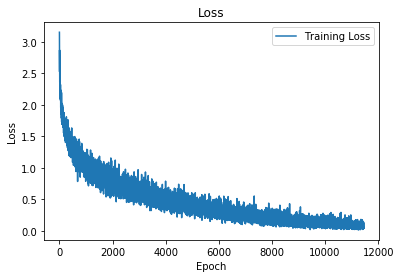

***** test accuracy: 0.746


In [10]:
reset_and_train(Options(num_cnn = 5, use_batch_norm = True, use_dropout = True, num_fc = 3, num_epoch = 30))

-----  Your model  -----
-----  Sample model  -----
intput layer: (?, 32, 32, 3)
conv1 layer: (?, 16, 16, 32)
conv2 layer: (?, 8, 8, 64)
conv3 layer: (?, 4, 4, 64)
conv4 layer: (?, 2, 2, 128)
conv5 layer: (?, 2, 2, 128)
flat layer: (?, 512)
fc6 layer: (?, 384)
fc7 layer: (?, 192)
fc8 layer: (?, 10)
-----  Start training  -----
train for epoch 0
iteration (0): loss = 366.350, accuracy = 0.109
iteration (50): loss = 246.131, accuracy = 0.281
iteration (100): loss = 199.821, accuracy = 0.414
iteration (150): loss = 191.336, accuracy = 0.438
iteration (200): loss = 184.323, accuracy = 0.453
iteration (250): loss = 169.992, accuracy = 0.508
iteration (300): loss = 167.664, accuracy = 0.508
iteration (350): loss = 169.631, accuracy = 0.484
validation for epoch 0
-  epoch 0: validation accuracy = 0.557
train for epoch 1
iteration (400): loss = 158.482, accuracy = 0.531
iteration (450): loss = 169.508, accuracy = 0.539
iteration (500): loss = 149.721, accuracy = 0.508
iteration (550): loss = 1

-  epoch 16: validation accuracy = 0.714
train for epoch 17
iteration (6500): loss = 64.170, accuracy = 0.797
iteration (6550): loss = 49.235, accuracy = 0.859
iteration (6600): loss = 62.577, accuracy = 0.836
iteration (6650): loss = 38.869, accuracy = 0.891
iteration (6700): loss = 44.319, accuracy = 0.898
iteration (6750): loss = 70.577, accuracy = 0.812
iteration (6800): loss = 53.793, accuracy = 0.859
iteration (6850): loss = 42.454, accuracy = 0.867
validation for epoch 17
-  epoch 17: validation accuracy = 0.715
train for epoch 18
iteration (6900): loss = 43.310, accuracy = 0.859
iteration (6950): loss = 29.615, accuracy = 0.930
iteration (7000): loss = 53.022, accuracy = 0.820
iteration (7050): loss = 44.783, accuracy = 0.867
iteration (7100): loss = 46.098, accuracy = 0.844
iteration (7150): loss = 66.895, accuracy = 0.828
iteration (7200): loss = 59.882, accuracy = 0.812
iteration (7250): loss = 66.004, accuracy = 0.812
validation for epoch 18
-  epoch 18: validation accuracy

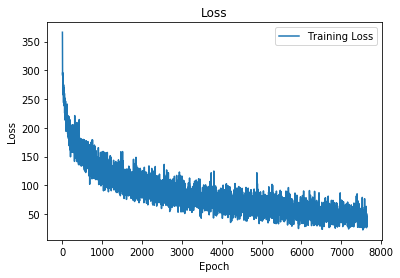

***** test accuracy: 0.697
Model saved in lib/tf_models/problem2/csci-599_mine.ckpt


In [24]:
# Clear old computation graphs
tf.reset_default_graph()

# Hyper parameters that achieve 70% test accuracy
options = Options(num_cnn = 5, use_dropout = False, num_fc = 3, num_epoch = 20)

#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

with tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)) as sess:
    with tf.device('/gpu:0'):
        model = YourModel(options)
        model.train(sess, X_train, Y_train, X_val, Y_val)
        accuracy = model.evaluate(sess, X_test, Y_test)
        print('***** test accuracy: %.3f' % accuracy)
        # Save your model
        saver = tf.train.Saver()
        model_path = saver.save(sess, "lib/tf_models/problem2/csci-599_mine.ckpt")
        print("Model saved in %s" % model_path)

In [ ]:
tf.reset_default_graph()

# Load your model
model = YourModel()
sess = tf.Session()
saver = tf.train.Saver()
saver.restore(sess, "lib/tf_models/problem2/csci-599_mine.ckpt")